### Imports

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from typing import NamedTuple, Callable

import sys
import os
sys.path.append('../')
sys.path.append('../power_law_rf')
import optimizers
# from power_law_rf.power_law_rf import PowerLawRF
from power_law_rf.ode import ODEInputs
# from laprop_ode import ode_laprop_log_implicit, LaPropParams
# from laprop_optax import laprop
from power_law_rf.least_squares import lsq_streaming_optax_simple
import power_law_rf.deterministic_equivalent as theory

key = random.PRNGKey(0)

In [2]:
# theory_limit_loss, theory_rho_weights

########################################################
# Power-law random features regression class
# Theory tools are callable from the class
# Instantiate the class for a sample of the PLRF
########################################################

class PowerLawRF:
  """
  A class that generates power-law random features regression problems.

  This class creates synthetic regression problems with power-law decaying eigenvalues
  and target coefficients. The features are generated by first sampling random Gaussian
  features and then scaling them according to a power law.

  Attributes:
      alpha (float): Power law exponent for eigenvalue decay
      beta (float): Power law exponent for target coefficient decay
      W (ndarray): Random features matrix of shape (v, d)
      v (int): Hidden dimensionality
      d (int): Embedded dimensionality
      x_grid (ndarray): Grid of indices from 1 to v, shape (1,v)
      population_eigenvalues (ndarray): Power-law decaying eigenvalues
      b (ndarray): Power-law decaying target coefficients
      population_trace (float): Sum of population eigenvalues
      checkW (ndarray): Scaled random features matrix
      checkb (ndarray): Scaled target coefficients
  """

  def __init__(self, alpha, beta, W):
      self.alpha = alpha
      self.beta = beta
      self.W = W
      self.v = self.W.shape[0]
      self.d = self.W.shape[1]
      self.x_grid=jnp.arange(1, self.v+1).reshape(1,self.v)
      self.population_eigenvalues = self.x_grid**(-self.alpha)
      self.b = self.x_grid.transpose()**(-beta)
      self.population_trace = jnp.sum(self.population_eigenvalues)
      self.checkW = W * self.population_eigenvalues.T
      self.checkb = self.x_grid.transpose()**(-alpha-beta)

  @classmethod
  def initialize_random(cls, alpha, beta, v, d, key):
      """
      Creates a new power_law_RF instance with randomly initialized features.

      Args:
          alpha (float): Power law exponent for eigenvalue decay
          beta (float): Power law exponent for target coefficient decay
          v (int): Hidden dimensionality
          d (int): Embedded dimensionality
          key (PRNGKey): JAX random number generator key

      Returns:
          power_law_RF: A new instance with randomly sampled features matrix W
                        scaled to have variance 1/d
      """
      # Sample random features matrix with variance 1/d
      W = random.normal(key, (v, d)) / jnp.sqrt(d)
      return cls(alpha=alpha, beta=beta, W=W)

  def get_population_risk(self, w):
      """
      Calculates the population risk for given weights.

      The population risk is the expected squared error over the data distribution.
      For power-law random features regression, this can be computed analytically
      without sampling data.

      Args:
          w (ndarray): Weight vector of shape (d,)

      Returns:
          float: Population risk value
      """
      # Project weights onto random features
      proj = jnp.matmul(self.checkW, w)

      # Calculate population risk using eigenvalues and target coefficients
      risk = jnp.sum((proj - self.checkb)**2)
      return risk / 2

  def get_hessian_spectra(self):
    """Get eigenvalues of the Hessian matrix of the problem

    Returns
    -------
    ndarray
        Array containing the eigenvalues of the Hessian matrix, computed as
        the squared singular values of the checkW matrix.
    """
    _, s, _ =jnp.linalg.svd(self.checkW,full_matrices=False)
    return s**2

  def get_rhos(self):
    """Get squared-projections of the residual (b) in the direction of the eigenmodes of the Hessian.

    Returns
    -------
    ndarray
        Array containing the squared-projections of the residual vector b onto the eigenvectors
        of the Hessian matrix, normalized by the corresponding eigenvalues.
    """
    Uvec, s, _ =jnp.linalg.svd(self.checkW,full_matrices=False)

    #Compute < ( D^1/2 W W^T D^(1/2) - z)^{-1}, D^(1/2) b >
    check_beta_weight = jnp.tensordot(self.checkb,Uvec,axes=[[0],[0]])[0]

    rhos = (check_beta_weight)**2 / s**2
    rhos.astype(jnp.float32)
    return rhos


  def get_data(self, key, batch):
      """
      Generates a batch of synthetic data points.

      Args:
          key (PRNGKey): JAX random number generator key
          batch (int): Number of data points to generate

      Returns:
          tuple: (X, y) where:
              X (ndarray): Input features of shape (batch, d)
              y (ndarray): Target values of shape (batch, 1)
      """
      # Generate random features
      x = random.normal(key, (batch, self.v))

      return jnp.matmul(x, self.checkW), jnp.matmul(x, self.checkb)

  def get_theory_limit_loss(self):
      """Returns the theoretical limit of the loss (residual risk) for the current model parameters.

      Calculates the theoretical prediction for the residual risk level (risk at infinite time)
      using the model's alpha, beta, v (number of random features), and d (input dimension) parameters.

      Returns:
          float: Theoretical prediction for the residual risk level
      """
      return theory.theory_limit_loss(self.alpha,self.beta,self.v,self.d)

  def get_theory_rho_weights(self,num_splits, a, b, xs_per_split = 10000):
    """Generate the initial rho_j's deterministically.
    This performs many small contour integrals each surrounding the real eigenvalues
    where the vector a contains the values for the lower (left) edges of the
    contours and the vector b contains the values of the upper (right) edges of the
    contours.
    """
    v, d, alpha, beta = self.v, self.d, self.alpha, self.beta
    return theory.theory_rho_weights(v, d, alpha, beta, num_splits, a, b, xs_per_split)


### Globals

In [10]:
ALPHA = 1.0
BETALIST = [0.3, 0.7, 1.0, 1.3]
# BETALIST = [0.7]
V = 2000
D = 500
SGDBATCH = 1
STEPS = 10**5

### LaProp stochastic algorithm

In [4]:
import optax
import jax
import jax.numpy as jnp
from typing import Any, Callable, NamedTuple, Optional, Union

ScalarOrSchedule = Union[float, Callable[[int], float]]

def _bias_correction(moment, decay, count):
    """Perform bias correction. This becomes a no-op as count goes to infinity."""
    return moment / (1 - decay ** count)

class ScaleByLaPropState(NamedTuple):
    """State for the LaProp algorithm."""
    count: jnp.ndarray
    m: optax.Updates
    v: optax.Updates

def scale_by_laprop(
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-8,
    eps_root: float = 0.0,
    debias: bool = True
) -> optax.GradientTransformation:
    """Rescale updates according to the LaProp algorithm.

    LaProp differs from Adam in that it normalizes gradients before momentum accumulation.

    Args:
        b1: Decay rate for the exponentially weighted average of grads.
        b2: Decay rate for the exponentially weighted average of squared grads.
        eps: Small constant applied to denominator to improve numerical stability.
        eps_root: Small constant applied to denominator inside the square root to
                  improve numerical stability.
        debias: Whether to use bias correction.

    Returns:
        A GradientTransformation.
    """
    def init_fn(params):
        m = jax.tree_util.tree_map(jnp.zeros_like, params)
        v = jax.tree_util.tree_map(jnp.zeros_like, params)
        return ScaleByLaPropState(count=jnp.zeros([], jnp.int32), m=m, v=v)

    def update_fn(updates, state, params=None):
        del params

        # Update step count
        count_inc = state.count + 1

        # Update v (EMA of squared gradients)
        v = jax.tree_util.tree_map(
            lambda v, g: b2 * v + (1 - b2) * jnp.square(g),
            state.v, updates
        )

        # Compute bias corrected v if required
        v_corrected = v
        if debias:
            v_corrected = jax.tree_util.tree_map(
                lambda v: _bias_correction(v, b2, count_inc), v
            )

        # Normalize gradients by sqrt(v) before momentum update (this is the key difference from Adam)
        normalized_grads = jax.tree_util.tree_map(
            lambda g, v: g / (jnp.sqrt(v + eps_root) + eps),
            updates, v_corrected
        )

        # Update m (EMA of normalized gradients)
        m = jax.tree_util.tree_map(
            lambda m, g: b1 * m + (1 - b1) * g,
            state.m, normalized_grads
        )

        # Compute bias corrected m if required
        m_corrected = m
        if debias:
            m_corrected = jax.tree_util.tree_map(
                lambda m: _bias_correction(m, b1, count_inc), m
            )

        return m_corrected, ScaleByLaPropState(count=count_inc, m=m, v=v)

    return optax.GradientTransformation(init_fn, update_fn)

def laprop(
    learning_rate: ScalarOrSchedule,
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-8,
    eps_root: float = 0.0,
    debias: bool = True,
) -> optax.GradientTransformation:
    """LaProp optimizer.

    References:
    Ziyin et al. "LaProp: Separating Momentum and Adaptivity in Adam"
    https://arxiv.org/abs/2002.04839

    Args:
        learning_rate: A fixed global scaling factor or a callable that
            produces a scaling factor.
        b1: Decay rate for the exponentially weighted average of grads.
        b2: Decay rate for the exponentially weighted average of squared grads.
        eps: Small constant applied to denominator to improve numerical stability.
        eps_root: Small constant applied to denominator inside the square root to
                  improve numerical stability.
        debias: Whether to use bias correction.

    Returns:
        A GradientTransformation.
    """
    return optax.chain(
        scale_by_laprop(b1=b1, b2=b2, eps=eps, eps_root=eps_root, debias=debias),
        optax.scale_by_learning_rate(learning_rate)
    )

In [14]:
# Part 1: Generate data for each beta value
results_by_beta = []
for beta in BETALIST:
    key, newkey = random.split(key)
    # Create problem instance for this beta
    problem = PowerLawRF.initialize_random(ALPHA, beta, V, D, key=newkey)

    # Run LaProp with fixed learning rate
    key, newkey = random.split(key)
    laprop_optimizer = laprop(learning_rate=0.001)
    laprop_times, laprop_losses = lsq_streaming_optax_simple(
        newkey,
        problem.get_data,
        SGDBATCH,
        STEPS,
        laprop_optimizer,
        jnp.zeros((problem.d,1)),
        problem.get_population_risk
    )

    # Run LaProp with cosine decay for different step sizes
    laprop_cos_decay_results = []
    step_lengths = []
    current_steps = 1000
    while current_steps <= STEPS:
        step_lengths.append(current_steps)
        current_steps *= 4

    for steps in step_lengths:
        cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=steps)
        laprop_cos_decay = laprop(learning_rate=cos_decay)
        key, newkey = random.split(key)
        times, losses = lsq_streaming_optax_simple(
            newkey,
            problem.get_data,
            SGDBATCH,
            STEPS,
            laprop_cos_decay,
            jnp.zeros((problem.d,1)),
            problem.get_population_risk
        )
        laprop_cos_decay_results.append((times, losses))

    results_by_beta.append({
        'beta': beta,
        'laprop': (laprop_times, laprop_losses),
        'laprop_cos': laprop_cos_decay_results
    })

100%|██████████| 106/106 [00:33<00:00,  3.15it/s]


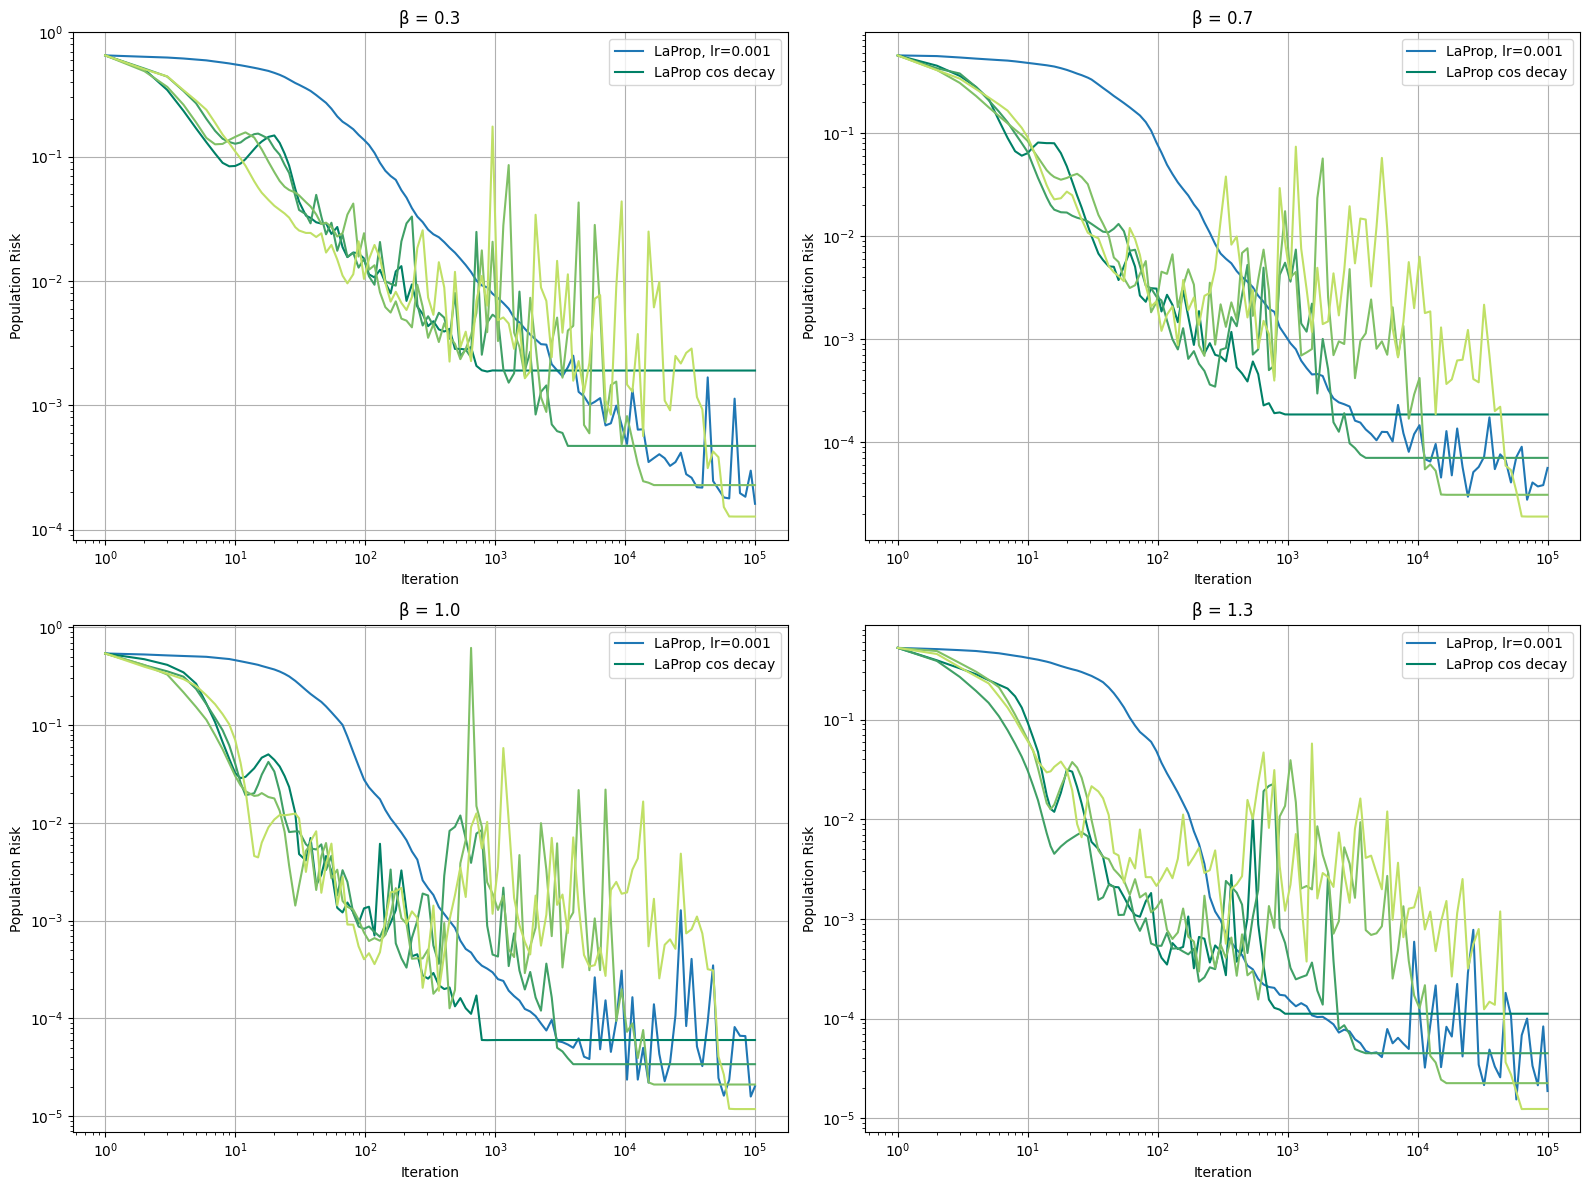

In [15]:
# Part 2: Create plots for empirical results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, result in enumerate(results_by_beta):
    beta = result['beta']
    laprop_times, laprop_losses = result['laprop']
    laprop_cos_decay_results = result['laprop_cos']

    # Plot on the corresponding subplot
    axes[idx].loglog(laprop_times+1, laprop_losses, label='LaProp, lr=0.001')

    colors = cm.summer(jnp.linspace(0, 0.75, len(laprop_cos_decay_results)))
    for (times, losses), color in zip(laprop_cos_decay_results, colors):
        if jnp.array_equal(color, colors[0]):
            axes[idx].loglog(times+1, losses, color=color, label='LaProp cos decay')
        else:
            axes[idx].loglog(times+1, losses, color=color)

    axes[idx].set_xlabel('Iteration')
    axes[idx].set_ylabel('Population Risk')
    axes[idx].set_title(f'β = {beta}')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()

### LaProp ODE

In [7]:
import jax
import jax.numpy as jnp
from typing import NamedTuple, Callable, Union
from power_law_rf.ode import ODEInputs


class LaPropParams(NamedTuple):
    beta1: Callable[[float], float]  # momentum decay parameter
    eta: Callable[[float], float]    # learning rate function


def ode_laprop_log_implicit(
    inputs: ODEInputs,
    opt_hparams: LaPropParams,
    batch: int,
    D: int,
    t_max: float,
    dt: float,
    approximate = False,
):
    """Generate the theoretical solution to LaProp using normalized gradients.

    Parameters
    ----------
    inputs : ODEInputs
        eigs_K : array d
            eigenvalues of covariance matrix (W^TDW)
        rho_init : array d
            initial rho_j's (rho_j^2)
        chi_init : array (d)
            initialization of chi's
        sigma_init : array (d)
            initialization of sigma's (xi^2_j)
        risk_infinity : scalar
            represents the risk value at time infinity

    opt_hparams : optimizer hyperparameters for LaProp
        beta1 : function(time)
            momentum decay parameter
        eta : function(time)
            learning rate function

    batch : int
        batch size
    D : int
        number of eigenvalues (i.e. shape of eigs_K)
    t_max : float
        The number of epochs
    dt : float
        time step used in Euler

    Returns
    -------
    t_grid: numpy.array(float)
        the time steps used, which will discretize (0,t_max) into n_grid points
    risks: numpy.array(float)
        the values of the risk
    """
    # Map to DANA's parameter convention for easier comparison
    delta = lambda f: 1 - opt_hparams.beta1(f)  # Decay rate for momentum
    g1 = lambda f: 1 - opt_hparams.beta1(f)     # Coefficient for gradient contribution to momentum
    g2 = lambda f: 0                            # Not used in LaProp
    g3 = opt_hparams.eta                        # Learning rate

    # Extract problem parameters
    eigs_K = inputs.eigs_K
    rho_init, chi_init, sigma_init = inputs.rho_init, inputs.chi_init, inputs.sigma_init
    risk_infinity = inputs.risk_infinity
    times = jnp.arange(0, jnp.log(t_max), step=dt, dtype=jnp.float32)
    risk_init = inputs.risk_infinity + jnp.sum(inputs.eigs_K * inputs.rho_init)

    def inverse_3x3(omega):
        # Extract matrix elements
        a11, a12, a13 = omega[0][0], omega[0][1], omega[0][2]
        a21, a22, a23 = omega[1][0], omega[1][1], omega[1][2]
        a31, a32, a33 = omega[2][0], omega[2][1], omega[2][2]

        # Calculate determinant
        det = (a11*a22*a33 + a12*a23*a31 + a13*a21*a32
               - a13*a22*a31 - a11*a23*a32 - a12*a21*a33)

        # Calculate each element of inverse matrix
        inv = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

        inv[0][0] = (a22*a33 - a23*a32) / det
        inv[0][1] = (a13*a32 - a12*a33) / det
        inv[0][2] = (a12*a23 - a13*a22) / det

        inv[1][0] = (a23*a31 - a21*a33) / det
        inv[1][1] = (a11*a33 - a13*a31) / det
        inv[1][2] = (a13*a21 - a11*a23) / det

        inv[2][0] = (a21*a32 - a22*a31) / det
        inv[2][1] = (a12*a31 - a11*a32) / det
        inv[2][2] = (a11*a22 - a12*a21) / det

        return jnp.array(inv)

    def omega_full(time_plus, grad_norm):
        # First row: rho dynamics - parameter update uses momentum directly
        omega_11 = -2.0 * batch * g2(time_plus) * eigs_K + batch * (batch + 1.0) * g2(time_plus)**2 * eigs_K**2
        omega_12 = g3(time_plus)**2 * jnp.ones_like(eigs_K)  # No normalization here
        omega_13 = 2.0 * g3(time_plus) * (-1.0 + g2(time_plus) * batch * eigs_K)
        omega_1 = jnp.array([omega_11, omega_12, omega_13])

        # Second row: sigma dynamics - momentum accumulates normalized gradients
        omega_21 = batch * (batch + 1.0) * g1(time_plus)**2 * eigs_K**2 / grad_norm**2  # Normalization here
        omega_22 = (-2.0 * delta(time_plus) + delta(time_plus)**2) * jnp.ones_like(eigs_K)
        omega_23 = 2.0 * g1(time_plus) * eigs_K * batch * (1.0 - delta(time_plus)) / grad_norm  # And here
        omega_2 = jnp.array([omega_21, omega_22, omega_23])

        # Third row: chi dynamics - cross-correlations
        omega_31 = g1(time_plus) * batch * eigs_K / grad_norm  # Normalization here
        omega_32 = -g3(time_plus) * jnp.ones_like(eigs_K)
        omega_33 = -delta(time_plus) - g2(time_plus) * batch * eigs_K
        omega_3 = jnp.array([omega_31, omega_32, omega_33])

        omega = jnp.array([omega_1, omega_2, omega_3])
        return omega

    def omega_approximate(time_plus, grad_norm):
        # Simplified version with fewer higher-order terms
        omega11 = -2.0 * batch * g2(time_plus) * eigs_K
        omega12 = 0.0 * jnp.ones_like(eigs_K)
        omega13 = 2.0 * g3(time_plus) * -1.0 * jnp.ones_like(eigs_K)
        omega1 = jnp.array([omega11, omega12, omega13])

        omega21 = 0.0 * jnp.ones_like(eigs_K)  # Simplified
        omega22 = (-2.0 * delta(time_plus)) * jnp.ones_like(eigs_K)
        omega23 = 2.0 * g1(time_plus) * eigs_K * batch / grad_norm  # Normalized gradients
        omega2 = jnp.array([omega21, omega22, omega23])

        omega31 = g1(time_plus) * batch * eigs_K / grad_norm  # Normalized gradients
        omega32 = -g3(time_plus) * jnp.ones_like(eigs_K)
        omega33 = -delta(time_plus) - g2(time_plus) * batch * eigs_K
        omega3 = jnp.array([omega31, omega32, omega33])

        omega = jnp.array([omega1, omega2, omega3])  # 3 x 3 x d
        return omega

    def ode_update(carry, time):
        v, risk = carry
        time_plus = jnp.exp(time + dt)

        # Use sqrt(risk) as proxy for gradient normalization
        grad_norm = jnp.sqrt(risk)

        omega = omega_approximate(time_plus, grad_norm) if approximate else omega_full(time_plus, grad_norm)
        identity = jnp.tensordot(jnp.eye(3), jnp.ones(D), 0)

        A = inverse_3x3(identity - (dt * time_plus) * omega)  # 3 x 3 x d

        # Gamma term represents the stochastic noise contribution
        Gamma = jnp.array([batch * g2(time_plus)**2,
                           batch * g1(time_plus)**2 / grad_norm**2, 0.0])
        z = jnp.einsum('i, j -> ij', jnp.array([1.0, 0.0, 0.0]), eigs_K)
        G_lambda = jnp.einsum('i,j->ij', Gamma, inputs.eigs_K)  # 3 x d

        x_temp = v + dt * time_plus * inputs.risk_infinity * G_lambda
        x = jnp.einsum('ijk, jk -> ik', A, x_temp)

        y = jnp.einsum('ijk, jk -> ik', A, G_lambda)

        v_new = x + (dt * time_plus * y * jnp.sum(x * z) /
                    (1.0 - dt * time_plus * jnp.sum(y * z)))

        risk_new = risk_infinity + jnp.sum(eigs_K * v_new[0])
        return (v_new, risk_new), risk

    init_carry = (jnp.array([rho_init, sigma_init, chi_init]), risk_init)
    _, risks = jax.lax.scan(ode_update, init_carry, times)
    return jnp.exp(times), risks / 2

In [16]:
# Initialize lists to store ODE results for each beta
ode_results_by_beta = []

for beta in BETALIST:
    # Initialize parameters for this beta
    initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
    initY = jnp.zeros(problem.d, dtype=jnp.float32)

    # Get theory rhos for this beta
    fake_eigs, rho_init = theory.theory_rhos(problem.alpha, beta, problem.d)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)

    riskInftyTheory = theory.theory_limit_loss(problem.alpha, beta, problem.v, problem.d)

    Dt = 10**(-3)

    # Run LaProp with cosine decay for different step sizes
    laprop_cos_decay_results = []
    step_lengths = []
    current_steps = 1000
    while current_steps <= STEPS:
        step_lengths.append(current_steps)
        current_steps *= 4

    for steps in step_lengths:
        cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=steps)
        beta1 = optax.schedules.constant_schedule(0.9)
        # Run ODE for this beta
        odeTimes, odeRisks = ode_laprop_log_implicit(
            ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
            LaPropParams(beta1, cos_decay),
            SGDBATCH, problem.d, STEPS, Dt)
        laprop_cos_decay_results.append((odeTimes, odeRisks))

    ode_results_by_beta.append({
        'beta': beta,
        'laprop_cos_decay': laprop_cos_decay_results,
    })

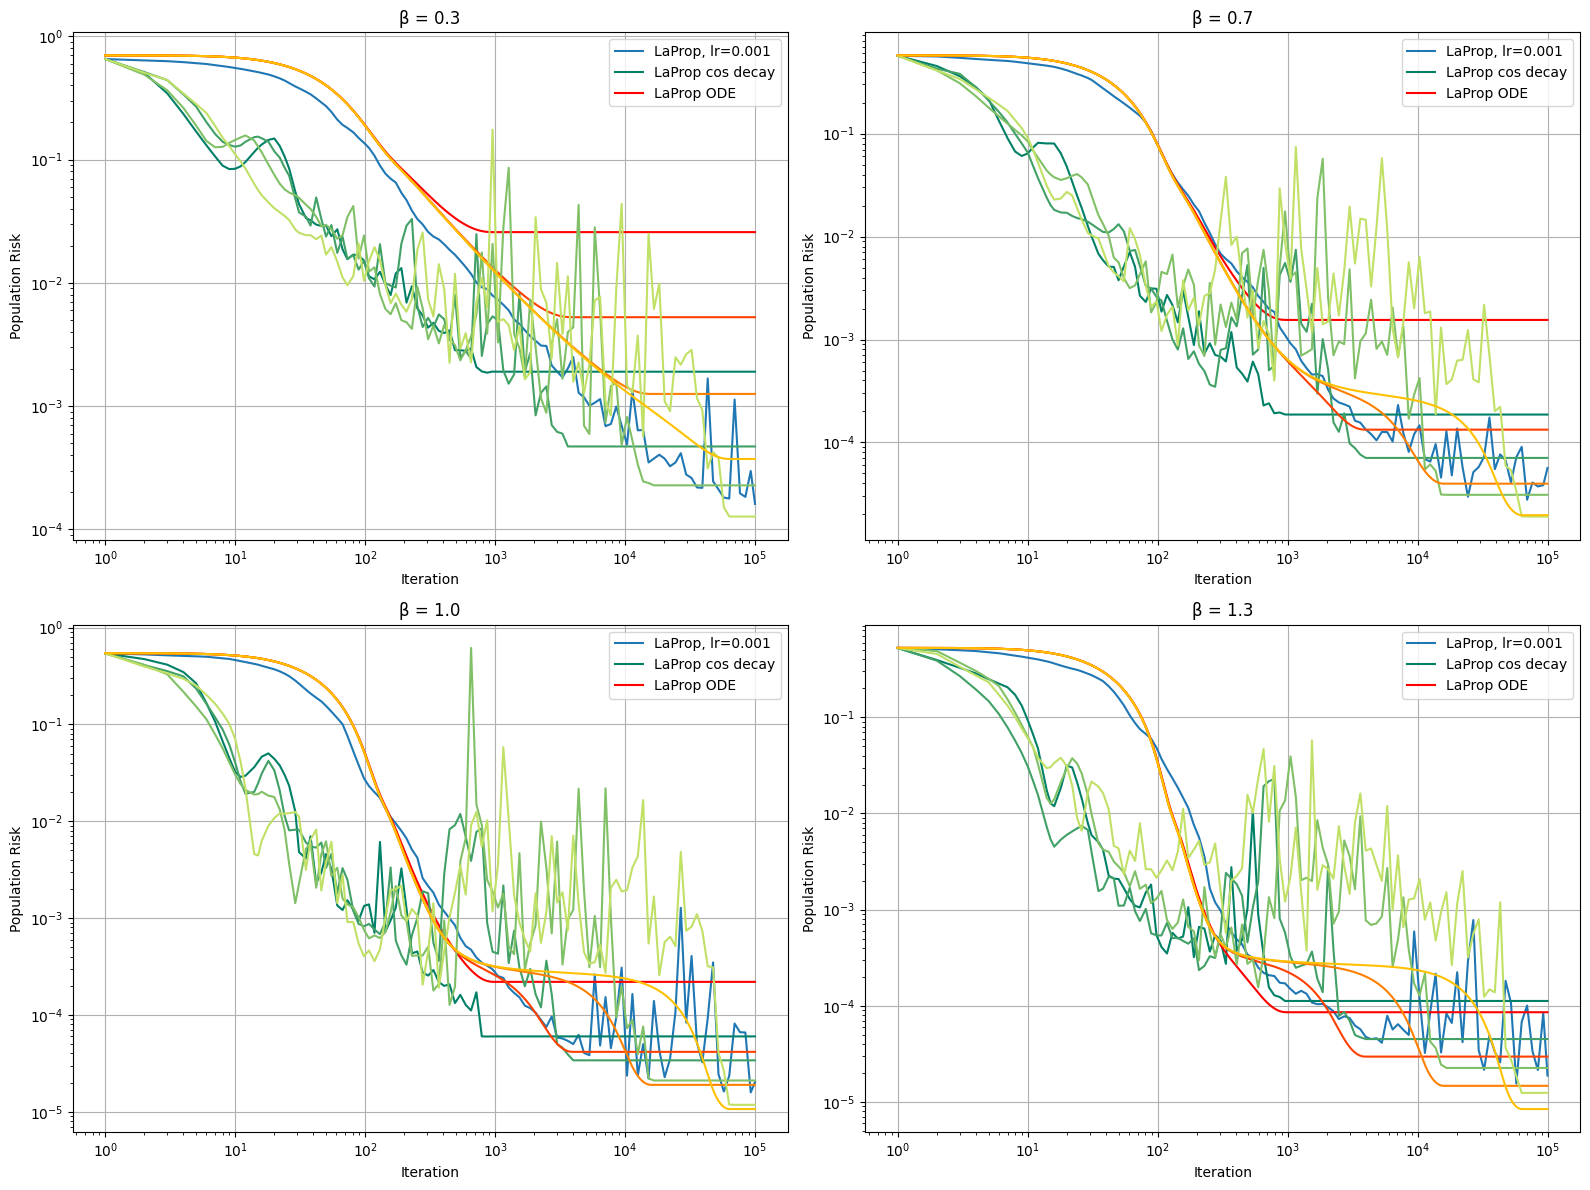

In [17]:
# Create plots comparing empirical results with ODE predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (result, ode_result) in enumerate(zip(results_by_beta, ode_results_by_beta)):
    beta = result['beta']
    laprop_times, laprop_losses = result['laprop']
    laprop_cos_decay_results = result['laprop_cos']
    laprop_ode_results = ode_result['laprop_cos_decay']

    # Plot on the corresponding subplot
    axes[idx].loglog(laprop_times+1, laprop_losses, label='LaProp, lr=0.001')

    laprop_colors = cm.summer(jnp.linspace(0, 0.75, len(laprop_cos_decay_results)))
    ode_colors = cm.autumn(jnp.linspace(0, 0.75, len(laprop_ode_results)))

    for (times, losses), (ode_times, ode_losses), color, ode_color in zip(
            laprop_cos_decay_results, laprop_ode_results, laprop_colors, ode_colors):
        if jnp.array_equal(color, laprop_colors[0]):
            axes[idx].loglog(times+1, losses, color=color, label='LaProp cos decay')
            axes[idx].loglog(ode_times, ode_losses, color=ode_color, label='LaProp ODE')
        else:
            axes[idx].loglog(times+1, losses, color=color)
            axes[idx].loglog(ode_times, ode_losses, color=ode_color)

    axes[idx].set_xlabel('Iteration')
    axes[idx].set_ylabel('Population Risk')
    axes[idx].set_title(f'β = {beta}')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()

### Large-scale limit experiments

In [11]:
# Studying LaProp behavior with different learning rates in the large-scale limit
large_ode_results_by_beta = []
lr_scales = [0.1/(2**i) for i in range(15)]
step_lengths = []
current_steps = 1000
while current_steps <= STEPS:
    step_lengths.append(current_steps)
    current_steps *= 4

large_d = 100000
large_v = 500000

for beta in BETALIST:
    for lr_scale in lr_scales:
        # Initialize parameters for this beta in the large-scale limit
        initTheta = jnp.zeros(large_d, dtype=jnp.float32)
        initY = jnp.zeros(large_d, dtype=jnp.float32)

        # Get theory rhos for this beta
        fake_eigs, rho_init = theory.theory_rhos(ALPHA, beta, large_d)
        sigma_init = jnp.zeros_like(rho_init)
        chi_init = jnp.zeros_like(rho_init)

        riskInftyTheory = theory.theory_limit_loss(ALPHA, beta, large_v, large_d)

        Dt = 10**(-3)

        # Run LaProp with cosine decay for different step sizes
        laprop_cos_decay_results = []

        for steps in step_lengths:
            cos_decay = optax.cosine_decay_schedule(init_value=lr_scale, decay_steps=steps)
            beta1 = optax.schedules.constant_schedule(0.9)
            # Run ODE for this beta
            odeTimes, odeRisks = ode_laprop_log_implicit(
                ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
                LaPropParams(beta1, cos_decay),
                SGDBATCH, large_d, STEPS, Dt)
            laprop_cos_decay_results.append((odeTimes, odeRisks))

        large_ode_results_by_beta.append({
            'beta': beta,
            'lr_scale': lr_scale,
            'laprop_cos_decay': laprop_cos_decay_results,
        })

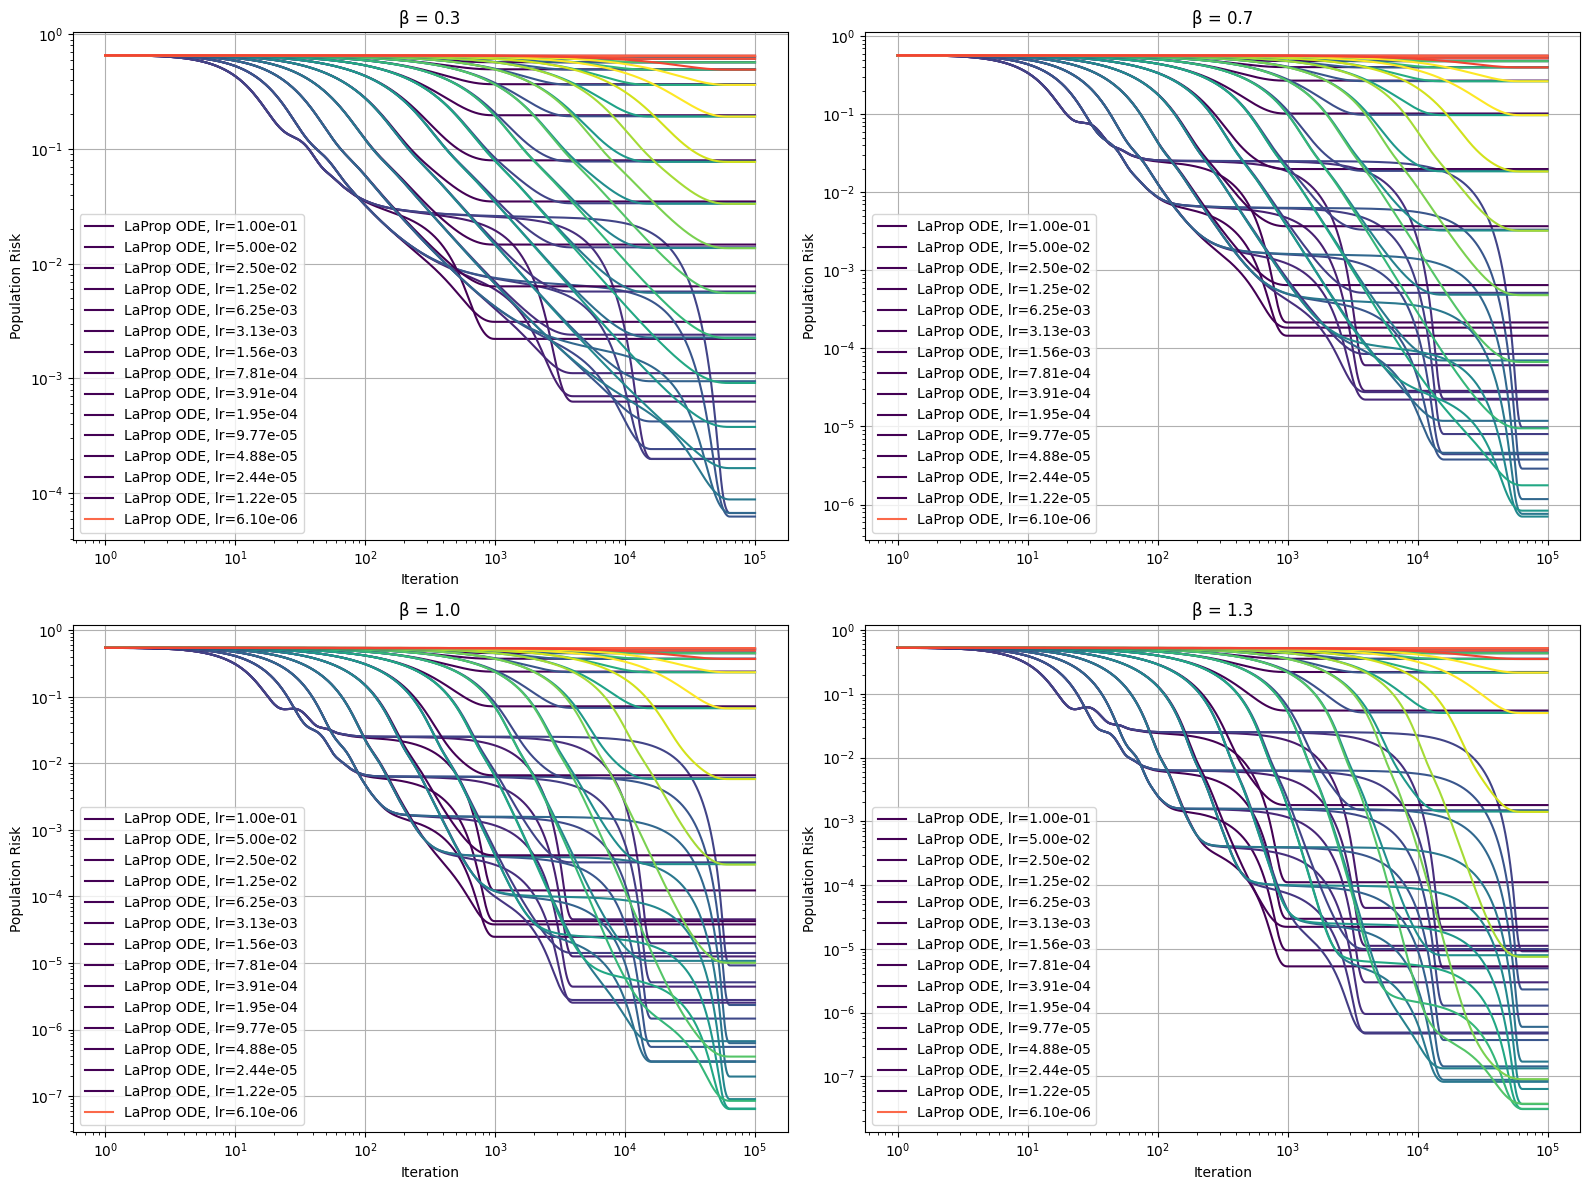

In [12]:
# Create plots for large-scale ODE results with different learning rates
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

beta_to_idx = {beta: i for i, beta in enumerate(BETALIST)}

for ode_result in large_ode_results_by_beta:
    beta = ode_result['beta']
    lr_scale = ode_result['lr_scale']
    laprop_ode_results = ode_result['laprop_cos_decay']

    ax = axes[beta_to_idx[beta]]

    # Plot on the corresponding subplot
    shift = lr_scales.index(lr_scale) / len(lr_scales)
    if shift == max(lr_scales.index(scale) / len(lr_scales) for scale in lr_scales):
        ode_colors = cm.Reds(jnp.linspace(0.5, 0.6, len(laprop_ode_results)))
    else:
        ode_colors = cm.viridis(jnp.linspace(0, 0.2 + shift, len(laprop_ode_results)))

    for (ode_times, ode_losses), ode_color in zip(laprop_ode_results, ode_colors):
        if jnp.array_equal(ode_color, ode_colors[0]):
            ax.loglog(ode_times, ode_losses, color=ode_color, label=f'LaProp ODE, lr={lr_scale:.2e}')
        else:
            ax.loglog(ode_times, ode_losses, color=ode_color)

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'β = {beta}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()

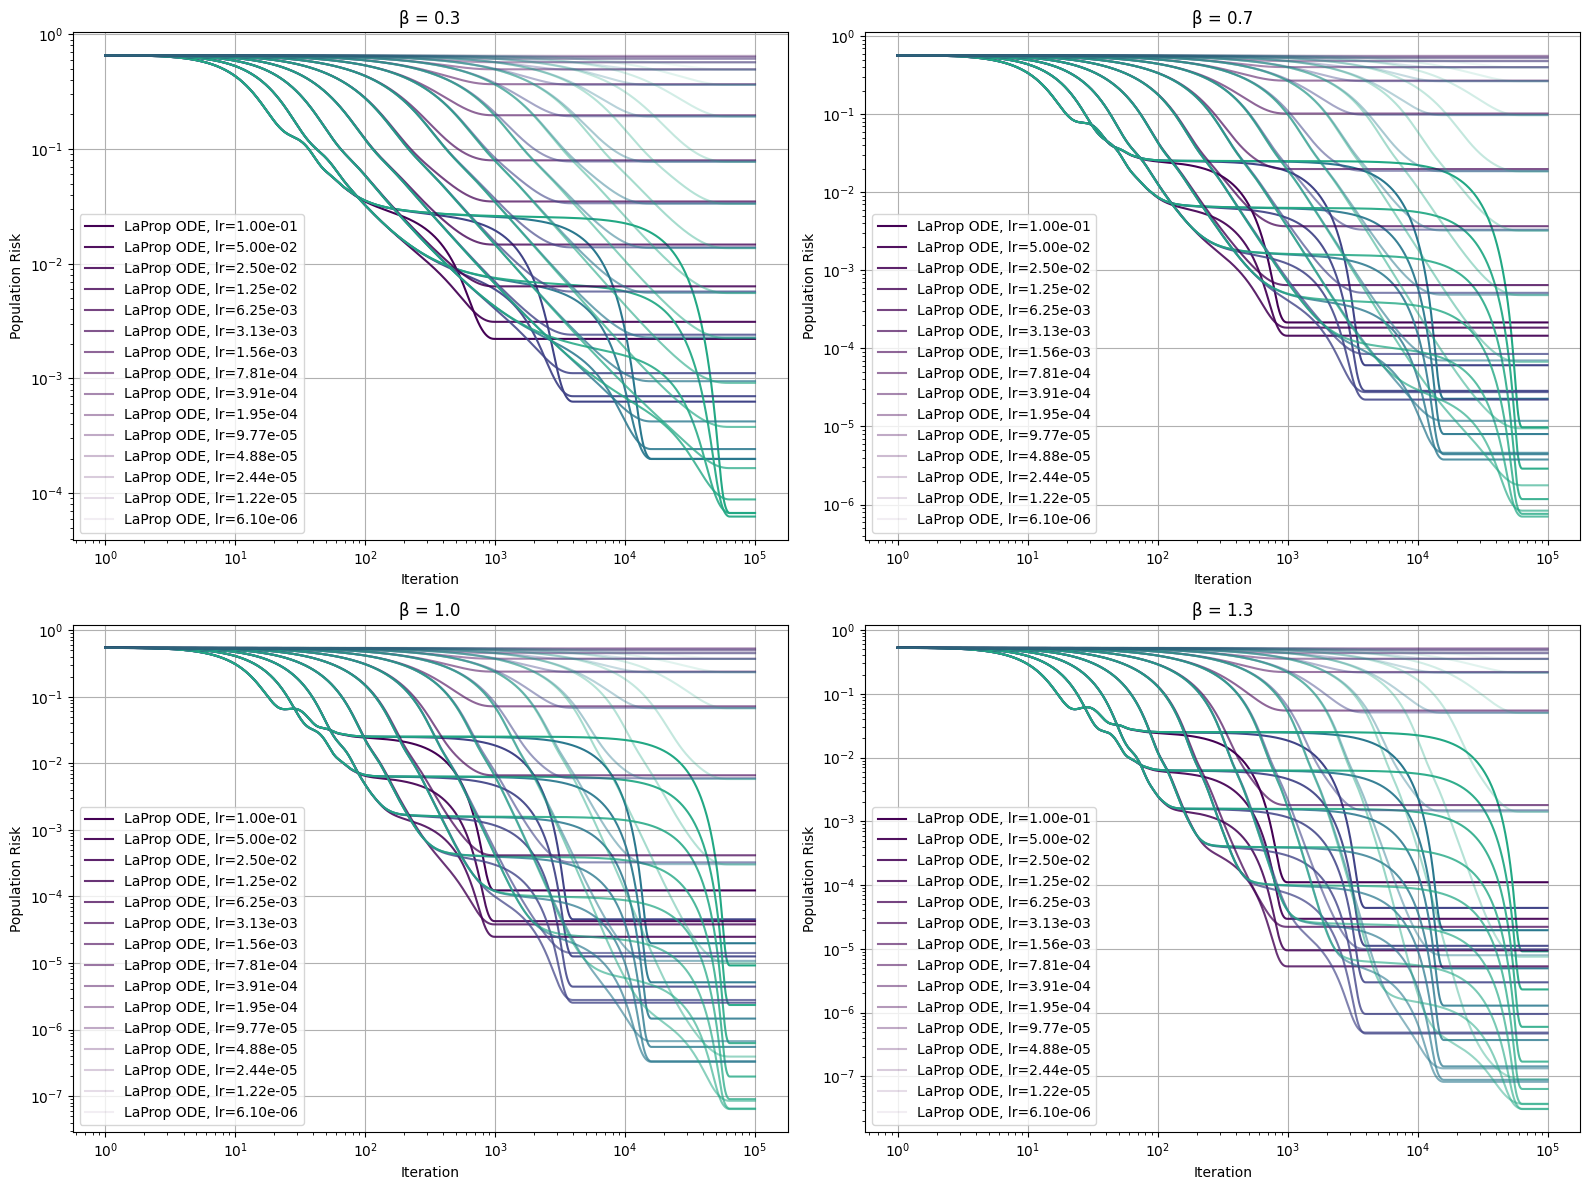

In [13]:
# Alternative visualization of large-scale ODE results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

beta_to_idx = {beta: i for i, beta in enumerate(BETALIST)}

for ode_result in large_ode_results_by_beta:
    beta = ode_result['beta']
    lr_scale = ode_result['lr_scale']
    laprop_ode_results = ode_result['laprop_cos_decay']

    ax = axes[beta_to_idx[beta]]

    # Plot on the corresponding subplot with varying opacity based on learning rate
    alpha = 1 - (lr_scales.index(lr_scale) / len(lr_scales))

    for idx, (ode_times, ode_losses) in enumerate(laprop_ode_results):
        color = cm.viridis(0.8 * idx / len(laprop_ode_results))
        ax.loglog(ode_times, ode_losses, color=color, alpha=alpha,
                 label=f'LaProp ODE, lr={lr_scale:.2e}' if idx == 0 else "")

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'β = {beta}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('laprop_cos_decay_scaling_law.pdf')